In [1]:
import torch 
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append('./continual_protoparts/src/')
from networks.protopartnet import construct_PPNet
from networks.network import LLL_Net_PPNet
from datasets.data_loader import get_loaders
from datasets.dataset_config import dataset_config

import utils
from networks.protopartnet import push

utils.seed_everything(seed=0)

In [2]:
import pandas as pd

In [3]:
from matplotlib import pyplot as plt

In [4]:
trn_loader, val_loader, tst_loader, psh_loader, taskcla = get_loaders(
    ['cub_200_2011_cropped'], 
#     ['cars_gmum'], 
    4,
    None,
    80, 
    num_workers=6,
    pin_memory=False)

In [5]:
exp_path = './' #PATH


In [111]:
num_tasks = 3
num_cls = 50
depth = 256
focal = False

sim_vals = []
labels = []
logits_all = []
dists = []
conv_outs_all = []

for num_task in range(num_tasks + 1):
    init_model = construct_PPNet(
                'resnet34', pretrained=True, img_size=224,
                prototype_shape=(int(10 * num_cls), depth, 1, 1), num_classes=int(num_cls),
                prototype_activation_function='log',
                add_on_layers_type='linear',
                focal=focal,
                warm_num=5,
                push_at=8,
                num_push_tune=5,
                incorrect_weight_btw_tasks=False,
                share_add_ons=True
                )
    net = LLL_Net_PPNet(init_model, remove_existing_head=True)
    model = torch.load(f'{exp_path}/models/task{num_task}.ckpt')
    for i in range(num_task + 1):
        net.add_head(num_cls)

    net.load_state_dict(model)
    net.cuda()
    
    similarity = []
    label = []
    logit_all = []
    dist = []
    conv_outs = []

    for t in range(num_task + 1):
        net.eval()
        with torch.no_grad():
            for img, lab in tst_loader[t]:
                img = img.cuda()
                lab = lab.cuda()
                out = net(img)
                conv_out = net.model.conv_features(img)
                conv_outs.append(conv_out)
                logits = [out[i][1] for i in range(len(out))]
                min_dists = [out[i][2] for i in range(len(out))]
                min_dists = torch.cat(min_dists, dim=1)
                dist.append(min_dists.cpu().numpy())
                sims = net.heads[0].distance_2_similarity(min_dists)
                sims = sims.reshape(-1, num_cls*(num_task + 1), 10)
                similarity.append(sims.cpu().numpy())
                label.append(lab.cpu().numpy())
                logit_all.append(torch.cat(logits, dim=1).cpu().numpy())
    sim_vals.append(np.concatenate(similarity))
    labels.append(np.concatenate(label))
    logits_all.append(np.concatenate(logit_all))
    dists.append(np.concatenate(dist))
    conv_outs_all.append(conv_outs)
#     break

In [214]:
last_task_logits = logits_all[-1]

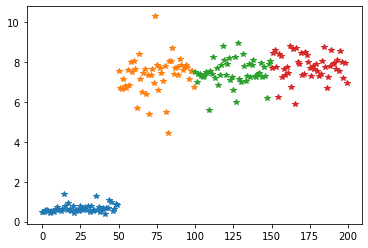

In [216]:
plt.plot(last_task_logits[:len(labels[0])].mean(0)[:50], '*')
plt.plot(range(50, 100), last_task_logits[len(labels[0]):len(labels[1])].mean(0)[50:100], '*')
plt.plot(range(100, 150), last_task_logits[len(labels[1]):len(labels[2])].mean(0)[100:150], '*')
plt.plot(range(150, 200), last_task_logits[len(labels[2]):len(labels[3])].mean(0)[150:], '*')

In [224]:
lamb_p = 0.9

In [225]:
last_task_only_logits = last_task_logits[len(labels[2]):len(labels[3])]
(last_task_only_logits.argmax(1) < 50).sum()

3

In [226]:
lamb = (lamb_p - 0.05) * (len(last_task_only_logits) - (last_task_only_logits.argmax(1) < 50).sum())
val_t = 0.01 
last_task_only_logits_temp = last_task_only_logits.copy()
last_task_only_logits_temp[:, 0:50] = last_task_only_logits[:, 0:50] + val_t
perc = (len(last_task_only_logits) - (last_task_only_logits.argmax(1) < 50).sum()) / len(last_task_only_logits)
while perc * len(last_task_only_logits) > lamb:
    val_t += 0.005
    last_task_only_logits_temp[:, 0:50] = last_task_only_logits[:, 0:50]  + val_t
    perc = (len(last_task_only_logits) - (last_task_only_logits_temp.argmax(1) < 50).sum()) / len(last_task_only_logits)

last_task_logits_balanced[:, :50] = last_task_logits_balanced[:, :50] + val_t


In [228]:
lamb = (lamb_p + 0.05) * (len(last_task_only_logits) - ((last_task_only_logits[:, 50:].argmax(1) < 50)).sum())
val_t = 0.01 
last_task_only_logits_temp = last_task_only_logits.copy()
last_task_only_logits_temp[:, 50:100] = last_task_only_logits[:, 50:100] + val_t
perc = (len(last_task_only_logits) - ((last_task_only_logits[:, 50:].argmax(1) < 50)).sum()) / len(last_task_only_logits)
while perc * len(last_task_only_logits) > lamb:
    val_t += 0.005
    last_task_only_logits_temp[:, 50:100] = last_task_only_logits[:, 50:100] + val_t
    perc = (len(last_task_only_logits) - ((last_task_only_logits_temp[:, 50:].argmax(1) < 50)).sum()) / len(last_task_only_logits)

last_task_logits_balanced[:, 50:100] = last_task_logits_balanced[:, 50:100] + val_t


In [229]:
lamb = (lamb_p + 0.05) * (len(last_task_only_logits) - ((last_task_only_logits[:, 100:].argmax(1) < 50)).sum())
val_t = 0.01 
last_task_only_logits_temp = last_task_only_logits.copy()
last_task_only_logits_temp[:, 100:150] = last_task_only_logits[:, 100:150] + val_t
perc = (len(last_task_only_logits) - ((last_task_only_logits[:, 100:].argmax(1) < 50)).sum()) / len(last_task_only_logits)
while perc * len(last_task_only_logits) > lamb:
    val_t += 0.005
    last_task_only_logits_temp[:, 100:150] = last_task_only_logits[:, 100:150] + val_t
    perc = (len(last_task_only_logits) - ((last_task_only_logits_temp[:, 100:].argmax(1) < 50)).sum()) / len(last_task_only_logits)

last_task_logits_balanced[:, 100:150] = last_task_logits_balanced[:, 100:150] + val_t


In [230]:
lamb = (lamb_p + 0.09) * (len(last_task_only_logits) - ((last_task_only_logits[:, 150:].argmax(1) < 50)).sum())
val_t = 0.01 
last_task_only_logits_temp = last_task_only_logits.copy()
last_task_only_logits_temp[:, 150:200] = last_task_only_logits[:, 150:200] + val_t
perc = (len(last_task_only_logits) - ((last_task_only_logits[:, 150:].argmax(1) < 50)).sum()) / len(last_task_only_logits)
while perc * len(last_task_only_logits) > lamb:
    val_t += 0.005
    last_task_only_logits_temp[:, 150:200] = last_task_only_logits[:, 150:200] + val_t
    perc = (len(last_task_only_logits) - ((last_task_only_logits_temp[:, 150:].argmax(1) < 50)).sum()) / len(last_task_only_logits)

last_task_logits_balanced[:, 150:200] = last_task_logits_balanced[:, 150:200] + val_t


In [231]:
s = (np.argmax(last_task_logits_balanced, axis=1) == labels[-1]).sum()

In [232]:
t0 = (np.argmax(last_task_logits_balanced, axis=1) == labels[-1])[:len(labels[0])].sum() / len(labels[0])
t1 = (np.argmax(last_task_logits_balanced, axis=1) == labels[-1])[len(labels[0]):len(labels[1])].sum() / (len(labels[1]) - len(labels[0]))
t2 = (np.argmax(last_task_logits_balanced, axis=1) == labels[-1])[len(labels[1]):len(labels[2])].sum() / (len(labels[2]) - len(labels[1]))
t3 = (np.argmax(last_task_logits_balanced, axis=1) == labels[-1])[len(labels[2]):len(labels[3])].sum() / (len(labels[3]) - len(labels[2]))

In [233]:
t0, t1, t2, t3, (t1+t2+t3+t0) / 4

(0.2570621468926554,
 0.4141891891891892,
 0.3324022346368715,
 0.44474761255115963,
 0.36210029581746894)

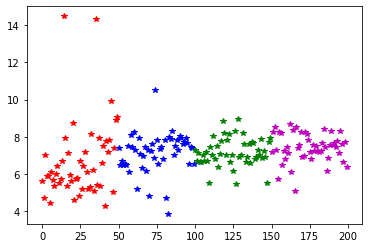

In [212]:
plt.plot(np.median(last_task_logits_balanced[:len(labels[0])], axis=0)[:50], 'r*')
plt.plot(range(50, 100), np.median(last_task_logits_balanced[len(labels[0]):len(labels[1])], axis=0)[50:100], 'b*')
plt.plot(range(100, 150), np.median(last_task_logits_balanced[len(labels[1]):len(labels[2])], axis=0)[100:150], 'g*')
plt.plot(range(150, 200), np.median(last_task_logits_balanced[len(labels[2]):len(labels[3])], axis=0)[150:], 'm*')